## Kutuphaneleri yukleyelim.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from PIL import Image
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, BatchNormalization, MaxPool2D
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
## görüntü verilerini önceden işlemek ve modele giriş olarak uygun hale getirmek için kullanılır.
from keras.callbacks import ModelCheckpoint
## eğitim sırasında modelin en iyi performans gösteren ağırlıklarını kaydetmek için kullanılır

In [2]:
#model = VGG16(weights = 'imagenet', include_top = True)

### Veriyi okuyalım.

In [3]:
data = pd.read_csv('face_2013/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
data.shape

(35887, 3)

In [5]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

#### Sutunların isimlerindeki boşlukları silelim

In [6]:
data.columns = data.columns.str.replace(' ', '')

### Training ve Test sayılarına bakalım

In [7]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Duygu ifadesine gore train test için bakalım.

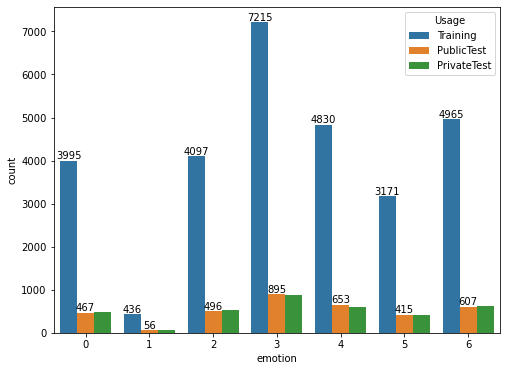

In [8]:
plt.figure(figsize = (8, 6))
ax = sbn.countplot(x = data['emotion'], hue = data['Usage'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

### Eğitim için kullanılan veri sayısına bakalım

In [9]:
np.unique(data['Usage'].values.ravel())
print(f"eğitim sayısı {len(data[data['Usage'] == 'Training'])} ")

eğitim sayısı 28709 


### Train_data için gorselleri işleyelim

In [10]:
train_data = pd.read_csv('face_2013/train.csv')
train_data.shape

(28709, 2)

In [11]:
train_data

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


### train için kullanacağımız resimleri işleyelim

In [12]:
train_pixels = train_data.pixels.str.split(" ").tolist()
train_pixels = pd.DataFrame(train_pixels)
train_images = train_pixels.astype(int).values
train_images = train_images.astype(float)
train_images

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 74.,  81.,  87., ..., 188., 187., 187.],
       [222., 227., 203., ..., 136., 136., 134.],
       [195., 199., 205., ...,   6.,  15.,  38.]])

In [13]:
train_images.shape

(28709, 2304)

### resimleri goruntulemek için bir fonksiyon yazalım

In [14]:
def show_img(resim):
    gosterilecek_resim = resim.reshape(48, 48)
    plt.imshow(gosterilecek_resim, cmap='gray')
    plt.axis('off')
    plt.show()

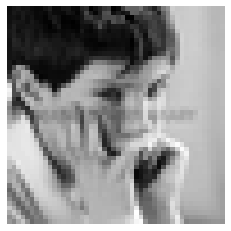

In [15]:
show_img(train_images[3])

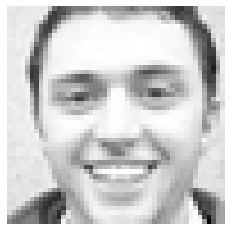

In [16]:
show_img(train_images[30])

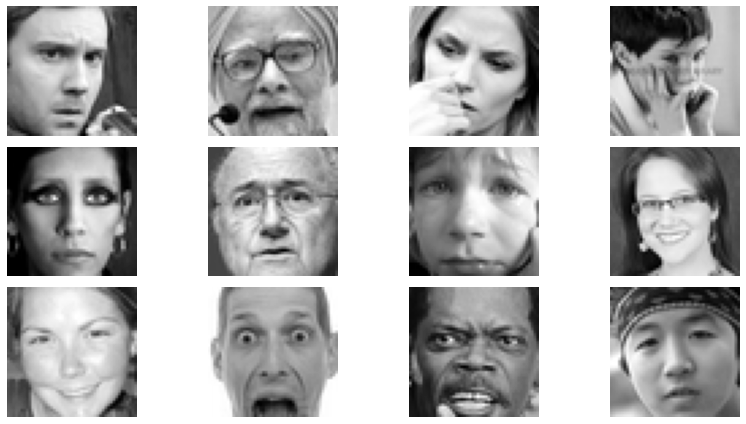

In [17]:
plt.figure(0, figsize = (12, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    image = train_images[i].reshape(48, 48)
    plt.imshow(image, cmap = 'gray')
plt.tight_layout()
plt.show()

### toplam kac farklı yuz ıfadesi olduğuna bakalım

In [18]:
train_labels_kind = train_data['emotion'].values.ravel()
train_labels_kind_count = np.unique(train_labels_kind).shape[0]
print(f'yuz ifade sayısı : {train_labels_kind_count}')

yuz ifade sayısı : 7


### Etiketler(y) için one hot code işlemi uygulayalım

In [19]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1   ## çok boyutlu bir NumPy dizisini tek boyutlu hale getirir.
    return labels_one_hot

In [20]:
y_train = dense_to_one_hot(train_labels_kind, train_labels_kind_count)
y_train = y_train.astype(np.uint8)

In [21]:
y_train.shape

(28709, 7)

### Test Verisi

#### Test Sayisina bakalım.

In [22]:
np.unique(data['Usage'].values.ravel())
print(f"test sayısı {len(data[data['Usage'] == 'PublicTest'])}")

test sayısı 3589


## Test için kullanacağımız resimleri işleyelim

In [23]:
test_data = data[data['Usage'] == 'PublicTest']
test_pixels = test_data.pixels.str.split(" ").tolist()
test_pixels = pd.DataFrame(test_pixels)
test_images = test_pixels.astype(int).values
test_images = test_images.astype(float)
test_images.shape

(3589, 2304)

### Test resimlerini goruntuleyelim

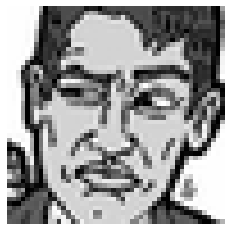

In [24]:
show_img(test_images[0])

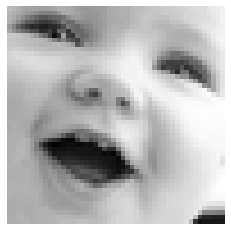

In [25]:
show_img(test_images[10])

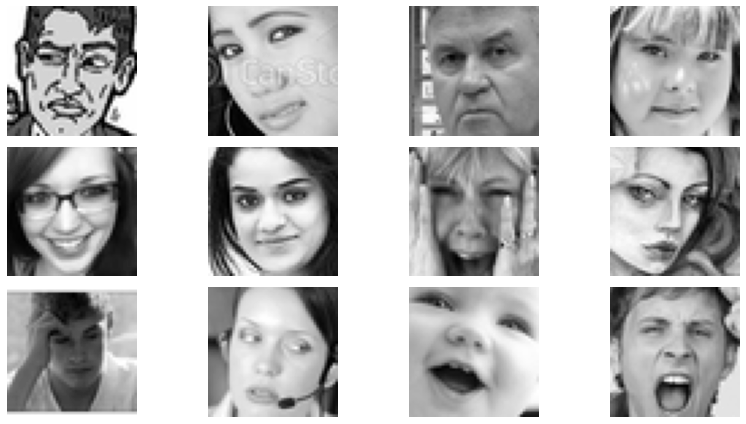

In [26]:
plt.figure(0, figsize = (12, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    image = test_images[i].reshape(48, 48)
    plt.imshow(image, cmap = 'gray')
plt.tight_layout()
plt.show()

### Modelimizi oluşturalım

In [38]:
model = Sequential()

# 1.katman
model.add(Conv2D(64, 3, data_format = 'channels_last', kernel_initializer = 'he_normal',
                input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 2.katman
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.6))

# 3.katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 4.katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 5.katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 6.katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.6))

# 7.katman
model.add(Conv2D(16, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# fully connected(tam bağlantı)
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

# çıkış katmanı
model.add(Dense(7))  # 7 duygu sınıfı var
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

## x_train ve x_test resimlerini modele uygun hale getirelim.

In [40]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

In [41]:
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

## y_test

In [42]:
test_labels_kind = test_data['emotion'].values.ravel()
test_labels_kind_count = np.unique(test_labels_kind).shape[0]
#print(f'yuz ifade sayısı : {test_labels_kind_count}')

y_test = dense_to_one_hot(test_labels_kind, test_labels_kind_count)
y_test = y_test.astype(int)

In [43]:
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

### En iyi ağirliklari kaydedelim.

In [44]:
check_pointer = ModelCheckpoint(filepath = 'models_face/model1.h5', verbose = 1, save_best_only = True)
history = model.fit(x_train, y_train, epochs = 5, shuffle = True, batch_size = 128,
                   validation_data = (x_test, y_test), callbacks = [check_pointer], verbose = 2)

model_json = model.to_json()
with open('models_face/model1_j.json', 'w') as json_file:
    json_file.write(model_json)

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.92835, saving model to models_face\model1.h5
225/225 - 191s - loss: 2.0341 - accuracy: 0.2164 - val_loss: 1.9284 - val_accuracy: 0.2499 - 191s/epoch - 850ms/step
Epoch 2/5

Epoch 2: val_loss improved from 1.92835 to 1.66088, saving model to models_face\model1.h5
225/225 - 185s - loss: 1.8054 - accuracy: 0.2705 - val_loss: 1.6609 - val_accuracy: 0.3427 - 185s/epoch - 822ms/step
Epoch 3/5

Epoch 3: val_loss improved from 1.66088 to 1.55101, saving model to models_face\model1.h5
225/225 - 186s - loss: 1.6699 - accuracy: 0.3433 - val_loss: 1.5510 - val_accuracy: 0.3962 - 186s/epoch - 825ms/step
Epoch 4/5

Epoch 4: val_loss improved from 1.55101 to 1.50629, saving model to models_face\model1.h5
225/225 - 185s - loss: 1.5623 - accuracy: 0.3874 - val_loss: 1.5063 - val_accuracy: 0.4057 - 185s/epoch - 823ms/step
Epoch 5/5

Epoch 5: val_loss improved from 1.50629 to 1.42375, saving model to models_face\model1.h5
225/225 - 187s - loss: 1.4781 -

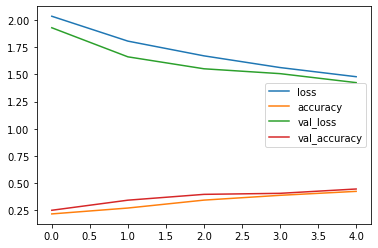

In [46]:
loss = pd.DataFrame(history.history)
loss.plot();

### Piksel değerlerini işleyelim

In [47]:
test = data[['emotion', 'pixels']][data['Usage'] == 'PrivateTest']
test['pixels'] = test['pixels'].apply(lambda im: np.fromstring(im, sep = ' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


### Sınıf etiketlerini one-hot encode formatina donusturelim

In [48]:
x_test_private = np.vstack(test['pixels'].values)
y_test_private = np.array(test['emotion'])
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [49]:
score = model.evaluate(x_test_private, y_test_private, verbose = 0)
print('Private test score : ', score[1] * 100)

Private test score :  45.27723491191864


### Kaydedilen en iyi ağırlıkları kullanalım.

In [50]:
en_iyi_model = load_model('models_face/model1.h5')

### Ornek bir resmi işleyip test edelim

In [57]:
image_path = 'images/ağlayan.jpg'
test_image_original = image.load_img(image_path)
test_image = image.load_img(image_path, target_size = (48, 48), color_mode = "grayscale")
test_data = image.img_to_array(test_image)
test_data = np.expand_dims(test_data, axis = 0)
test_data = np.vstack([test_data])
sonuc = en_iyi_model.predict(test_data, batch_size = 1)
sonuc

1/1 [==============================] - 0s 28ms/step


array([[0.15329623, 0.03362444, 0.18918301, 0.20310883, 0.20580176,
        0.0623212 , 0.1526645 ]], dtype=float32)

### Sonuçları şekle dokelim

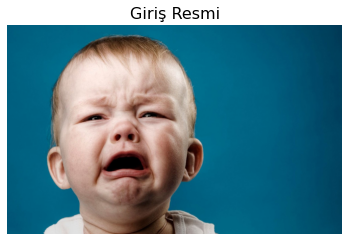

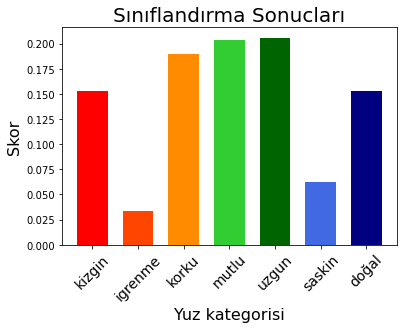

En yuksek sonuc :  uzgun


In [58]:
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'saskin', 'doğal']
ind = 0.1 + 0.6 * np.arange(len(class_names))
width = 0.4  # bar genişliği
color_list = ['red', 'orangered', 'darkorange', 'limegreen', 'darkgreen', 'royalblue', 'navy']

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize = 16)
plt.axis('off')
plt.show()

for i in range(len(class_names)):
    plt.bar(ind[i], sonuc[0][i], width, color = color_list[i])
plt.title('Sınıflandırma Sonucları', fontsize = 20)
plt.xlabel('Yuz kategorisi', fontsize = 16)
plt.ylabel('Skor', fontsize = 16)
plt.xticks(ind, class_names, rotation = 45, fontsize = 14)
plt.show()

print('En yuksek sonuc : ', class_names[np.argmax(sonuc)])